In [23]:

    print(paste("1: ", Sys.time()))
    flush.console()
    library(tidyverse)
    #list.files(path = "../input")
    library(gganimate)
    library(cowplot)
    library(repr)


    #turning off warnings
    options(warn=-1)

    #setting plot width and height
    options(repr.plot.width=15, repr.plot.height = 10)
    
    ####reading in non-tracking data

    #includes schedule info for games
    df_games <- read_csv("../input/nfl-big-data-bowl-2021/games.csv",
                        col_types = cols())
    
    #includes play-by-play info on specific plays
    df_plays <- read_csv("../input/nfl-big-data-bowl-2021/plays.csv",
                        col_types = cols())
    
    #includes background info for players
    df_players <<- read_csv("../input/nfl-big-data-bowl-2021/players.csv",
                      col_types = cols())
    
    ####Reading tracking data (needs to be done iteratively)

    #weeks of NFL season
    weeks <- seq(1, 17)
    
    #blank dataframe to store tracking data
    df_tracking <- data.frame()


    print(paste("2: ", Sys.time()))
    flush.console()  

    #iterating through all weeks
    for(w in weeks){
        
        #temperory dataframe used for reading week for given iteration
        df_tracking_temp <- read_csv(paste0("../input/nfl-big-data-bowl-2021/week",w,".csv"),
                                    col_types = cols())
        
        #storing temporary dataframe in full season dataframe
        df_tracking <- bind_rows(df_tracking_temp, df_tracking)                            
    
    }
    

    

    print(paste("3: ", Sys.time()))
    flush.console()  

    df_tracking <- df_tracking %>%
                mutate(x = ifelse(playDirection == "left", 120-x, x),
                       y = ifelse(playDirection == "left", 160/3 - y, y))
    

    
    #### declaring values for field coordinates

    # General field boundaries
    xmin <<- 0
    xmax <<- 160/3
    hash.right <<- 38.35
    hash.left <<- 12
    hash.width <<- 3.3
    


    print(paste("4: ", Sys.time()))
    flush.console()  

    ####merging plays and tracking data
    df_merged <<- inner_join(df_games,
                            df_plays,
                            by = c("gameId" = "gameId"))
    
    #merging games data to previously merged frame
    df_merged <<- inner_join(df_merged,
                            df_tracking,
                            by = c("gameId" = "gameId",
                                   "playId" = "playId"))
    


    
    #Delete temp variables from memory
    rm(df_tracking)
    rm(df_tracking_temp)
    rm(df_games)
    rm(df_plays)
    
    height_in_cm <- function(df_players){
                        heights <- c()
                          
                        for(i in df_players$height){
                            if(str_detect(i, "-")){
                                #Feets and inches
                                feets <- as.integer(strsplit(i, "-")[[1]][1])
                                inches <- as.integer(strsplit(i, "-")[[1]][2])
                                heights <- c(heights, ((feets * 30.48) + (inches * 2.54)))
                            }
                            else{
                                #Inches
                                heights <- c(heights, (as.integer(i) * 2.54))
                            }
                        }
  
                     return(heights)
    }

    df_players$height <- height_in_cm(df_players)
    rm(height_in_cm)
    
    print(paste("5: ", Sys.time()))
    flush.console()   

    ####Get Intended Receiver data

    #includes targetted receiver by play
    df_targetedReceiver <- read_csv("../input/nfl-big-data-bowl-2021-bonus/targetedReceiver.csv",
                          col_types = cols())
    
    playerNames <- df_players %>% select(nflId, displayName)
    
    df_targetedReceiver <- inner_join(df_targetedReceiver,
                                     playerNames,
                                     by = c("targetNflId" = "nflId"))
    


    print(paste("6: ", Sys.time()))
    flush.console()  
    
    
    df_merged <<- left_join(df_merged,
                            df_targetedReceiver,
              by = c("gameId" = "gameId",
                     "playId" = "playId"))
    

    print(paste("DF MERGER em Gigas (antes de consertar yardline): ",  object.size(df_merged) / 1000000))
    print(paste("7: ", Sys.time()))
    flush.console()  

    rm(playerNames)
    rm(df_targetedReceiver)
    

    
    df_merged <- df_merged %>% 
              mutate(yardlineSide = ifelse(is.na(yardlineSide), "left", yardlineSide), 
                     absoluteYardlineNumber = ifelse(yardlineSide == possessionTeam, yardlineNumber + 10, 110 - yardlineNumber))


    print(paste("DF MERGER em Gigas (antes de dropar linhas com pontuação NA): ",  object.size(df_merged) / 1000000))
    print(paste("8: ", Sys.time()))
    flush.console()  
    
    #isnotNA <- df_merged %>% mutate(isnotNA = ifelse(is.na(preSnapHomeScore), FALSE, TRUE))
    #df_merged <- df_merged[isnotNA$isnotNA,]
    df_merged <- df_merged %>% filter(is.na(preSnapHomeScore) == FALSE)
    #rm(isnotNA)
    

    print(paste("DF MERGER em Gigas (antes de trocar true/false por 0/1 em PI): ",  object.size(df_merged) / 1000000))
    print(paste("9: ", Sys.time()))
    flush.console()  

    #PI <- c(df_merged$isDefensivePI) == c(TRUE)
    #NOT_PI <- c(df_merged$isDefensivePI) == c(FALSE)
    #df_merged$isDefensivePI[PI] <- 1
    #df_merged$isDefensivePI[NOT_PI] <- 0
    
    #rm(PI)
    #rm(NOT_PI)
    rm(w)
    rm(weeks)
    
    df_merged$isDefensivePI[c(df_merged$isDefensivePI) == c(TRUE)] <- 1
    df_merged$isDefensivePI[c(df_merged$isDefensivePI) == c(FALSE)] <- 0
    

    print(paste("Consertou a coluna de Pass Interference - Memória (Gb disponíveis): ", as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE) )/ 1000000))

    print(paste("10: ", Sys.time()))
    flush.console()  
    
    df_merged <<- df_merged %>% mutate(is_ball = ifelse(displayName.x != "Football", 0, 1), is_defense = ifelse((team == "home" & homeTeamAbbr == possessionTeam)|(team == "away" & visitorTeamAbbr == possessionTeam)|(displayName.x == "Football"), 0, 1))

    

    print(paste("11: ", Sys.time()))
    flush.console()  


print(paste("Acabou - Memória (Gb disponíveis): ", as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE) )/ 1000000))

In [ ]:
ShowPlay <- function(GameId, PlayId){
 #Get the play info and player tracking
 play <- df_merged %>% filter(gameId == GameId, playId == PlayId)

 #Creating an object with only the play info
 playDetails <- play %>% select (playDescription, down, yardsToGo, quarter, week,homeTeamAbbr, visitorTeamAbbr,
                                possessionTeam, yardlineNumber, offenseFormation, personnelO, defendersInTheBox,
                                numberOfPassRushers, personnelD, epa) %>% distinct
  

 #Print info about the play
 print(paste("2008, week " , playDetails$week , ". The " , playDetails$visitorTeamAbbr , " visit " , playDetails$homeTeamAbbr ,
       ". It's " , playDetails$down , " to " , playDetails$yardsToGo , ", and it's " , playDetails$quarter , 
       " quarter. The " , playDetails$possessionTeam , " has the ball on the " , playDetails$yardlineNumber , 
      ". Their formation and personnel are " , playDetails$offenseFormation , playDetails$personnelO , ". Defense has " , 
       playDetails$defendersInTheBox , " mans in the box and are rushing " , playDetails$numberOfPassRushers , " guys on " , 
       playDetails$personnelD , " personnel. That play has earn " , playDetails$epa , " epa. What Happened: " , 
       playDetails$playDescription))
    
 #Animating the play
    
    #colors used for plot - using colors of team
    #TB vs CIN
    cols_fill <- c("#FB4F14", "#663300", "#A71930")
    cols_col <- c("#000000", "#663300", "#000000")
    plot_title <- str_trim(gsub("\\s*\\([^\\)]+\\)","",as.character(play$playDescription[1])))
    # Specific boundaries for a given play
    ymin <- max(round(min(play$x, na.rm = TRUE) - 10, -1), 0)
    ymax <- min(round(max(play$x, na.rm = TRUE) + 10, -1), 120)
    #hash marks
    df.hash <- expand.grid(x = c(0, 23.36667, 29.96667, xmax), y = (10:110))
    df.hash <- df.hash %>% filter(!(floor(y %% 5) == 0))
    df.hash <- df.hash %>% filter(y < ymax, y > ymin)
    #plotting
    ggplot() +
    #setting size and color parameters
    scale_size_manual(values = c(6, 4, 6), guide = FALSE) + 
    scale_shape_manual(values = c(21, 16, 21), guide = FALSE) +
    scale_fill_manual(values = cols_fill, guide = FALSE) + 
    scale_colour_manual(values = cols_col, guide = FALSE) +
    #adding hash marks
    annotate("text", x = df.hash$x[df.hash$x < 55/2], 
           y = df.hash$y[df.hash$x < 55/2], label = "_", hjust = 0, vjust = -0.2) + 
    annotate("text", x = df.hash$x[df.hash$x > 55/2], 
           y = df.hash$y[df.hash$x > 55/2], label = "_", hjust = 1, vjust = -0.2) + 
    #adding yard lines
    annotate("segment", x = xmin, 
           y = seq(max(10, ymin), min(ymax, 110), by = 5), 
           xend =  xmax, 
           yend = seq(max(10, ymin), min(ymax, 110), by = 5)) + 
    #adding field yardline text
    annotate("text", x = rep(hash.left, 11), y = seq(10, 110, by = 10), 
           label = c("G   ", seq(10, 50, by = 10), rev(seq(10, 40, by = 10)), "   G"), 
           angle = 270, size = 4) + 
    annotate("text", x = rep((xmax - hash.left), 11), y = seq(10, 110, by = 10), 
           label = c("   G", seq(10, 50, by = 10), rev(seq(10, 40, by = 10)), "G   "), 
           angle = 90, size = 4) + 
    #adding field exterior
    annotate("segment", x = c(xmin, xmin, xmax, xmax), 
           y = c(ymin, ymax, ymax, ymin), 
           xend = c(xmin, xmax, xmax, xmin), 
           yend = c(ymax, ymax, ymin, ymin), colour = "black") + 
    #adding players
    geom_point(data = play, aes(x = (xmax-y),
                                      y = x, 
                                      shape = team,
                                      fill = team,
                                      group = nflId,
                                      size = team,
                                      colour = team), 
             alpha = 0.7) +  
    #adding jersey numbers
    geom_text(data = play, aes(x = (xmax-y), y = x, label = jerseyNumber), colour = "white", 
            vjust = 0.36, size = 3.5) + 
    #applying plot limits
    ylim(ymin, ymax) + 
    coord_fixed() +
    #applying theme
    theme_nothing() + 
    theme(plot.title = element_text()) +
    #titling plot with play description
    labs(title = plot_title) +
    #setting animation parameters
    transition_time(frameId)  +
    ease_aes('linear') + 
    NULL
    
}

In [ ]:
VisualizeFrame <- function(frame){
    #colors used for plot - using colors of team
    #DEN vs OAK
    
    cols_fill <- c("#FB4F14", "#663300", "#A5ACAF")
    cols_col <- c("#000000", "#663300", "#000000")
    
    plot_title <- str_trim(gsub("\\s*\\([^\\)]+\\)","",as.character(frame$playDescription[1])))
    
    # Specific boundaries for a given play
    ymin <- max(round(min(frame$x, na.rm = TRUE) - 10, -1), 0)
    ymax <- min(round(max(frame$x, na.rm = TRUE) + 10, -1), 120)
    
    #hash marks
    df.hash <- expand.grid(x = c(0, 23.36667, 29.96667, xmax), y = (10:110))
    df.hash <- df.hash %>% filter(!(floor(y %% 5) == 0))
    df.hash <- df.hash %>% filter(y < ymax, y > ymin)
    
    
    #plotting
    ggplot() +
    
    #setting size and color parameters
    scale_size_manual(values = c(6, 4, 6), guide = FALSE) + 
    scale_shape_manual(values = c(21, 16, 21), guide = FALSE) +
    scale_fill_manual(values = cols_fill, guide = FALSE) + 
    scale_colour_manual(values = cols_col, guide = FALSE) +
    
    #adding hash marks
    annotate("text", x = df.hash$x[df.hash$x < 55/2], 
           y = df.hash$y[df.hash$x < 55/2], label = "_", hjust = 0, vjust = -0.2) + 
    annotate("text", x = df.hash$x[df.hash$x > 55/2], 
           y = df.hash$y[df.hash$x > 55/2], label = "_", hjust = 1, vjust = -0.2) + 
    
    #adding yard lines
    annotate("segment", x = xmin, 
           y = seq(max(10, ymin), min(ymax, 110), by = 5), 
           xend =  xmax, 
           yend = seq(max(10, ymin), min(ymax, 110), by = 5)) + 
    
    #adding field yardline text
    annotate("text", x = rep(hash.left, 11), y = seq(10, 110, by = 10), 
           label = c("G   ", seq(10, 50, by = 10), rev(seq(10, 40, by = 10)), "   G"), 
           angle = 270, size = 4) + 
    annotate("text", x = rep((xmax - hash.left), 11), y = seq(10, 110, by = 10), 
           label = c("   G", seq(10, 50, by = 10), rev(seq(10, 40, by = 10)), "G   "), 
           angle = 90, size = 4) + 
    
    #adding field exterior
    annotate("segment", x = c(xmin, xmin, xmax, xmax), 
           y = c(ymin, ymax, ymax, ymin), 
           xend = c(xmin, xmax, xmax, xmin), 
           yend = c(ymax, ymax, ymin, ymin), colour = "black") + 
    
    #adding players
    geom_point(data = frame, aes(x = (xmax-y),
                                      y = x, 
                                      shape = team,
                                      fill = team,
                                      group = nflId,
                                      size = team,
                                      colour = team), 
             alpha = 0.7) +  
    
    #adding jersey numbers
    geom_text(data = frame, aes(x = (xmax-y), y = x, label = jerseyNumber), colour = "white", 
            vjust = 0.36, size = 3.5) + 
    
    #applying plot limits
    ylim(ymin, ymax) + 
    coord_fixed() +
    
    #applying theme
    theme_nothing() + 
    theme(plot.title = element_text()) +
    
    #titling plot with play description
    labs(title = plot_title) #+
    
    #setting animation parameters
    #transition_time(frameId)  +
    #ease_aes('linear') + 
    #NULL
}

In [ ]:
get_snap_features <- function(frame){    
    
    frame1 <<- frame
    
    
    #Separate Defense, offense and ball
    defense <- frame %>% filter(is_defense == 1, is_ball == 0)
    offense <- frame %>% filter(is_defense == 0, is_ball == 0)
    ball <- frame %>% filter(is_ball == 1)
    
    
    #Filter defense properties
    defense <- defense %>% select(x, y, jerseyNumber, absoluteYardlineNumber, nflId)
    
    ###Get Deepest defender downfield
    deepest_def <- defense %>% filter(x == max(x)) %>% mutate(yard = (x - absoluteYardlineNumber)) %>% select(yard)
    
    ###Defense height (vertically distance between the defenders)
    def_height <- defense %>% mutate(def_height = max(x) - min(x)) %>% select (def_height) %>% distinct
    
    ###Defense Widght (horizontaly distance between the defenders)
    def_widght <- defense %>% mutate(def_widght = max(y) - min(y)) %>% select (def_widght) %>% distinct
    
    ###Number of defender deep (+10y) on snap           #Deep A    
    num_of_deep_def <- 0
    deep_defs <- frame1 %>% filter(x > (absoluteYardlineNumber + 10)) %>% mutate(qtd = n()) %>% select(qtd)
    if(is.na(deep_defs$qtd[1])){
        num_of_deep_def <- 0
    } else{
        num_of_deep_def <- deep_defs$qtd[1]
    }
    
    
    ###Closest defender to intended receiver - (get nflId) ("snap defender")
    idClosest <- 0
    ###Closest distance - Distance on the moment of snap between receiver and closest defender
    distClosest <- 0
    intended_receiver <- offense %>% filter(targetNflId == nflId) %>% select(x, y)
    
    
    
    #loop over defense players to see who is the closest defender to the intended receiver
    for(d in 1:nrow(defense)){
        defender <- defense[d, c("x", "y", "nflId")]
        
        pitagoras <- ((defender$y - intended_receiver$y) ^2) + ((defender$x - intended_receiver$x) ^2)
        
        distance <- sqrt(pitagoras)
        
        if(distance < distClosest | distClosest == 0){
            distClosest <- distance
            idClosest <- defender$nflId
        }
        
    }
    
    snap_features <- list("deepest_def" = deepest_def$yard, "def_height" = def_height$def_height, "def_widght" = def_widght$def_widght, "num_of_deep_def" = num_of_deep_def, "id_Closest_def" = idClosest, "dist_Closest_def" = distClosest)
    return(snap_features)
}

In [ ]:
get_throw_features <- function(frame){
    frame2 <<- frame
    
    #Separate Defense, offense and ball
    defense <- frame %>% filter(is_defense == 1, is_ball == 0)
    offense <- frame %>% filter(is_defense == 0, is_ball == 0)
    ball <- frame %>% filter(is_ball == 1) %>% mutate(yards_Downfield = (x - absoluteYardlineNumber))
    
    #Filter defense properties
    defense <- defense %>% select(x, y, jerseyNumber, absoluteYardlineNumber, nflId)
    
    ###Get Deepest defender downfield
    deepest_def <- defense %>% filter(x == max(x)) %>% mutate(yard = (x - absoluteYardlineNumber)) %>% select(yard)
    
    ###Number of defender deep (+10y) on throw           #Deep B    
    num_of_deep_def <- 0
    deep_defs <- frame1 %>% filter(x > (absoluteYardlineNumber + 10)) %>% mutate(qtd = n()) %>% select(qtd)
    if(is.na(deep_defs$qtd[1])){
        num_of_deep_def <- 0
    } else{
        num_of_deep_def <- deep_defs$qtd[1]
    }

    
    ###Closest defender to intended receiver - (get nflId) ("throw defender")
    idClosest <- 0
    ###Closest distance - Distance on the moment of throw between receiver and closest defender
    distClosest <- 0
    intended_receiver <- offense %>% filter(targetNflId == nflId) %>% mutate(yards_Downfield = (x - absoluteYardlineNumber)) %>% select(x, y, yards_Downfield)
    
    #loop over defense players to see who is the closest defender to the intended receiver
    for(d in 1:nrow(defense)){
        defender <- defense[d, c("x", "y", "nflId")]
        
        pitagoras <- ((defender$y - intended_receiver$y) ^2) + ((defender$x - intended_receiver$x) ^2)
        distance <- sqrt(pitagoras)
        
        if(distance < distClosest | distClosest == 0){
            distClosest <- distance
            idClosest <- defender$nflId
        }
    }
    
    throw_features <- list("deepest_def" = first(deepest_def$yard), "receiver_dist_downfield" = intended_receiver$yards_Downfield, "ball_yards_downfield" = ball$yards_Downfield, "time" = ball$frameId, "num_of_deep_def" = num_of_deep_def, "id_Closest_def" = idClosest, "dist_Closest_def" = distClosest)
    return(throw_features)
}

In [ ]:
get_1sba_features <- function(frame){
    frame <- frame %>% mutate(yards_Downfield = (x - absoluteYardlineNumber))
    frame3 <<- frame
    
    #Separate Defense, offense and ball
    defense <- frame %>% filter(is_defense == 1, is_ball == 0)
    offense <- frame %>% filter(is_defense == 0, is_ball == 0)
    ball <- frame %>% filter(is_ball == 1)
    
    #Closest defender to intended receiver - (get nflId) ("throw defender")
    idClosest <- 0
    #Closest distance - Distance on the moment of throw between receiver and closest defender
    distClosest <- 0
    intended_receiver <- offense %>% filter(targetNflId == nflId) %>% mutate(yards_Downfield = (x - absoluteYardlineNumber))
    
    #loop over defense players to see who is the closest defender to the intended receiver
    for(d in 1:nrow(defense)){
        defender <- defense[d, c("x", "y", "nflId")]
        
        pitagoras <- ((defender$y - intended_receiver$y) ^2) + ((defender$x - intended_receiver$x) ^2)
        distance <- sqrt(pitagoras)
        
        if(distance < distClosest | distClosest == 0){
            distClosest <- distance
            idClosest <- defender$nflId
        }
    }
    
    intended_receiver <- inner_join(intended_receiver,
                            df_players,
                            by = c("nflId" = "nflId"))
    closest_defender <- defense %>% filter(nflId == idClosest)
    closest_defender <- inner_join(closest_defender,
                            df_players,
                            by = c("nflId" = "nflId"))
    
    OneSec_bef_arr_features <- list("def_dist" = distClosest, "def_ac" = closest_defender$a, "def_speed" = closest_defender$s, "def_height" = as.numeric(closest_defender$height), "def_weight" = closest_defender$weight, "rec_ac" = intended_receiver$a, "rec_speed" = intended_receiver$s, "rec_height" = as.numeric(intended_receiver$height), "rec_weight" = intended_receiver$weight)
    return(OneSec_bef_arr_features)
}
     
        

In [ ]:
get_arrived_features <- function(frame, snap_def_id, throw_def_id){    
    #print("método get arrived features ")
    frame4 <<- frame
    
    #Separate Defense, offense and ball
    defense <- frame %>% filter(is_defense == 1, is_ball == 0)
    offense <- frame %>% filter(is_defense == 0, is_ball == 0)
    ball <- frame %>% filter(is_ball == 1) %>% mutate(yards_Downfield = (x - absoluteYardlineNumber))
    
    #Closest defender to intended receiver - (get nflId) ("throw defender")
    idClosest <- 0
    ###Closest distance - Distance on the moment of throw between receiver and closest defender
    distClosest <- 0
    intended_receiver <- offense %>% filter(targetNflId == nflId) %>% mutate(yards_Downfield = (x - absoluteYardlineNumber))
    
    
    #loop over defense players to see who is the closest defender to the intended receiver on the moment ball had arived
    for(d in 1:nrow(defense)){
        defender <- defense[d, c("x", "y", "nflId")]
        
        pitagoras <- ((defender$y - intended_receiver$y) ^2) + ((defender$x - intended_receiver$x) ^2)
        distance <- sqrt(pitagoras)
        
        if(distance < distClosest | distClosest == 0){
            distClosest <- distance
            idClosest <- defender$nflId
        }
    }
    
    #Get closest defender on the moment of snap and on the moment of throw
    snap_defender <- defense %>% filter(nflId == snap_def_id)
    throw_defender <- defense %>% filter(nflId == throw_def_id)
    
    ###Also, calculate their distance on the moment that ball had arrived
    pitagoras <- ((snap_defender$y - intended_receiver$y) ^2) + ((snap_defender$x - intended_receiver$x) ^2)
    snap_def_distance <- sqrt(pitagoras)
    ###
    pitagoras <- ((throw_defender$y - intended_receiver$y) ^2) + ((throw_defender$x - intended_receiver$x) ^2)
    throw_def_distance <- sqrt(pitagoras)
    
    intended_receiver <- inner_join(intended_receiver,
                            df_players,
                            by = c("nflId" = "nflId"))
    closest_defender <- defense %>% filter(nflId == idClosest)
    closest_defender <- inner_join(closest_defender,
                            df_players,
                            by = c("nflId" = "nflId"))
    
    ###Number of defender deep (+10y) on ball arrived           #Deep C   
    num_of_deep_def <- 0
    deep_defs <- frame1 %>% filter(x > (absoluteYardlineNumber + 10)) %>% mutate(qtd = n()) %>% select(qtd)
    if(is.na(deep_defs$qtd[1])){
        num_of_deep_def <- 0
    } else{
        num_of_deep_def <- deep_defs$qtd[1]
    }
    
    ###Defense losing by
    def_losing_by <- frame4 %>% mutate(def_losing_by = ifelse(possessionTeam[1] == homeTeamAbbr[1], 
                                                          preSnapHomeScore[1] - preSnapVisitorScore[1], 
                                                          preSnapVisitorScore[1] - preSnapHomeScore[1]))
    
    ###Minutes left in half of game
    #Get GameClock from playDescription, and remove ":" if necessary. The reason it's getting from playDescription is because most of the plays with PI calls doesn't have gameClock data on the gameClock column.
    minutes_left_in_quarter <- as.numeric(str_remove(substr(frame1$playDescription[1], 2, 3), "[:]"))
    
    if(frame1$quarter == 1 | frame1$quarter == 3){
    minutes_left_in_half <- (as.numeric(minutes_left_in_quarter) + 15)} else{ minutes_left_in_half <- as.numeric(minutes_left_in_quarter)}
    
    ###Minutes left in game
    minutes_left_in_game <-  (as.numeric(minutes_left_in_quarter) + ((4 - as.numeric(frame4$quarter[1])) * 15))
    if(minutes_left_in_game < 0){
        minutes_left_in_game <- 0
    }
    
    ###Is Defensive PI (label)
    isDefensivePI <- ball$isDefensivePI 
    
    ball_arrived_features <- list("def_dist" = distClosest, "def_ac" = closest_defender$a, "def_speed" = closest_defender$s, "def_height" = as.numeric(closest_defender$height), "def_weight" = closest_defender$weight, "rec_ac" = intended_receiver$a, "rec_speed" = intended_receiver$s, "rec_height" = as.numeric(intended_receiver$height), "rec_weight" = intended_receiver$weight, "snap_def_distance" = snap_def_distance, "throw_def_distance" = throw_def_distance, "ball_yards_downfield" = ball$yards_Downfield, "time" = ball$frameId , "num_of_deep_def" = num_of_deep_def, "def_losing_by" = def_losing_by$def_losing_by[1], "minutes_left_in_half" = minutes_left_in_half, "minutes_left_in_game" = minutes_left_in_game , "absolute_LOS" = ball$absoluteYardlineNumber, "is_defensive_PI" = isDefensivePI)
    return(ball_arrived_features)
}

In [ ]:
AgregateAllFeatures <- function(features){
    #Transform all features in a single vector of features
    
    #print(length(unlist(features)))
    return(c(unname(unlist(features))))  ##
    #return(unlist(features))
    #return(features)
}

In [2]:
'%!in%' <- function(x,y)!('%in%'(x,y))

#Create function to return a Play object
get_play <- function(GameId, PlayId){
    #print(paste("Entrando no GetPlays: ", GameId, PlayId))
    play <- df_merged %>% filter(gameId == GameId, playId == PlayId)
    
    #print(paste("Pegou a jogada no GetPlays: ", play[1,]$playId, play[1,]$gameId))
    return(play)
}


#Create function to return all features we're studying for the models
getFeatures <- function(play){
    
    play <- create_1sec_bef_Event(play)
    event_frames <- GetFramesByEvent(play)
    
    #Divide the play into the 4 key frames.
    frame_snap <- event_frames[["snap"]]
    frame_throw <- event_frames[["pass_forward"]]
    frame_One_sec_before_arr <- event_frames[["OneSecBeforeArrived"]]
    frame_arrived <-event_frames[["pass_arrived"]]
    
    #Get the features from each of the 4 frames.                                                   
    snap_features <- get_snap_features(frame_snap)          
    throw_features <- get_throw_features(frame_throw)
    one_sec_before_arr_features <- get_1sba_features(frame_One_sec_before_arr)
    arrived_features <- get_arrived_features(frame_arrived, snap_features$id_Closest_def, throw_features$id_Closest_def)
    
    
    #Return it as an array of vectors.
    features <- list(snap_features = snap_features, throw_features = throw_features, one_sec_before_arr_features = one_sec_before_arr_features, arrived_features = arrived_features)
    features2 <- AgregateAllFeatures(features)
    return(features2)
}

#Function to create the event "1 second before ball arrived"
create_1sec_bef_Event <- function(play){
    
    #Discover the name of the pass outcome event
    testArrived <- play %>% filter(event == "pass_arrived") %>% select(frameId) %>% distinct %>% head(1)
    testIncomplete <- play %>% filter(event == "pass_outcome_incomplete") %>% select(frameId) %>% distinct %>% head(1)
    testIntercepted <- play %>% filter(event == "pass_outcome_interception") %>% select(frameId) %>% distinct %>% head(1)
    testCaught <- play %>% filter(event == "pass_outcome_caught") %>% select(frameId) %>% distinct %>% head(1)
    
    
    eventName <- ""
    
    if(length(unname(unlist(testArrived))) > 0){
        eventName <- "pass_arrived"
    } else if (length(unname(unlist(testIncomplete))) > 0) {
        eventName <- "pass_outcome_incomplete"
    } else if (length(unname(unlist(testIntercepted))) > 0){
        eventName <- "pass_outcome_interception"
    } else if (length(unname(unlist(testCaught))) > 0){
        eventName <- "pass_outcome_caught"
    }
    
    
    #get frameID from between throw events
    
    throw_frameId <- play %>% filter(event == "pass_forward") %>% select(frameId) %>% distinct %>% head(1)
    
    arrived_frameId <- play %>% filter(event == c(eventName)) %>% select(frameId) %>% distinct %>% head(1)
    
    
    
    #Change the name of the event when ball hit the ground on an incomplete pass.
    frames <- c(play$event) == c(eventName)
    play$event[frames] <- "pass_arrived"
    

    
    
    OneSec_before_arrived_frameId <- 0
    
    #Get the exact frame of 1 second before ball arrived
    if ((arrived_frameId - throw_frameId) > 10) {
        #The forward pass took more than 1 second to arrive
        OneSec_before_arrived_frameId <- (arrived_frameId - 10)
    } else {
        #The forward pass took lass than 1 second to arrive, so, consider the first frame after the throw.
        OneSec_before_arrived_frameId <-(throw_frameId + 1)
    }
    
    
    #Create the event "1 second before ball arrived"
    frames <- c(play$frameId) == c(OneSec_before_arrived_frameId)
    play$event[frames] <- "1SecBeforeArrived"

    
    #print(play$event)
    return(play)
}

#Slice the play and return only the frames with the events we're studying
GetFramesByEvent <- function(play){
    e1 <- play %>% filter(event == "ball_snap")
    e2 <- play %>% filter(event == "pass_forward")
    e3 <- play %>% filter(event == "1SecBeforeArrived")
    arrived_Id <- play %>% filter(event == "pass_arrived") %>% select(frameId) %>% head(1)
    e4 <- play %>% filter(frameId == arrived_Id$frameId)
    frames <- list("snap" = e1, "pass_forward" = e2, "OneSecBeforeArrived" = e3, "pass_arrived" = e4)
    
    return(frames)
}

#Line below just execute it all using as parameter a beautiful YAC play by George Kittle
#getFeatures(get_play(2018110100, 2056))

#getFeatures(get_play(2018090600, 168))
#getFeatures(get_play(2018090600, 75))
#getFeatures(get_play(2018090901, 704))
#getFeatures(get_play(2018102808, 2190))
getFeatures(get_play(2018121602, 762))


In [ ]:
make_feature_extraction <- function(db){
    #Create blank matrix
    db_matrix <- matrix()
    count <- 0
    #Get features of all those plays and add them into the matrix
    for(p in 1:nrow(db)){
        print(paste(p, " / ", nrow(db)))
        count <- count + 1
        
        playId <- as.numeric(db[p,])[1]
        gameId <- as.numeric(db[p,])[2]
        print(paste(playId, gameId))
        
        flush.console() 
        tryCatch(
           {
              features <- getFeatures(get_play(gameId, playId))
              #print(paste("Length features = ", length(features)))
              matrix_features <- t(as.matrix(features))
              
              matrix_features_with_IDs <- matrix(data = c(gameId, playId), nrow = 1, ncol = 2)
              matrix_features_with_IDs <- cbind(matrix_features_with_IDs, matrix_features)   
              
              
              if(dim(db_matrix)[2] == 1) {
                  db_matrix <- matrix_features_with_IDs
              }
              else{
                  #print(paste("train_X dim: ", dim(train_X), " - matrix_features dim: ", dim(matrix_features)))
                  db_matrix <- rbind(db_matrix, matrix_features_with_IDs)
              }
           },
           error=function(cond) {
               print("catch.")
           }
        )
        
        
    }
    return(db_matrix)
}

In [ ]:
make_database <- function(data){
    library(caret)
    
    #Get all plays with a forward pass
    all_plays <- data
    
    #Divide into Train and Test
    set.seed(22)
    #             partition <- createDataPartition(y = pass_plays$isDefensivePI, p = 0.8, list = F)
    #             training <- pass_plays[partition, ]
    #             test <- pass_plays[-partition, ]
    
    
    ###
    # \/ Method to obtain the features into a matrix
    
    #train_X <- make_feature_extraction(training)
    #test_X <- make_feature_extraction(test)
    plays_X <<- make_feature_extraction(all_plays)
    rm(all_plays)
    rm(df_merged)
    
    #write.csv(train_X, "train_X.csv")
    #write.csv(test_X, "test_X.csv")
    write.csv(plays_X, "plays_X.csv")
    
}
#select all plays with forward passes
all_plays_fp <- df_merged %>% filter(event == "pass_forward", targetNflId == nflId ) %>% select(playId, gameId, isDefensivePI) %>% distinct
    

make_database(all_plays_fp)

In [1]:
library(tidyverse)
'%!in%' <- function(x,y)!('%in%'(x,y))

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
plays_X <- read.csv("../input/data01/plays_X.csv")
DeleteThisPlays <- read.csv("../input/data01/DeleteThisPlays.csv")

spec_data <- function(data){
    
        names(data) <- c("X",
                        "gameId",
                        "playId",
                        "snap_deepest_def",
                        "snap_def_height",
                        "snap_def_widght",
                        "snap_num_of_deep_def",
                        "snap_id_Closest_def",
                        "snap_dist_closest_def",
                        "throw_deepest_def_dist_downfield",
                        "throw_receiver_dist_downfield",
                        "throw_ball_yards_downfield",
                        "throw_time",
                        "throw_num_of_deep_def",
                        "throw_id_Closest_def",
                        "throw_dist_Closest_def",
                        "osba_dist_Closest_def",
                        "osba_def_ac",
                        "osba_def_speed",
                        "osba_def_height",
                        "osba_def_weight",
                        "osba_rec_ac",
                        "osba_rec_speed",
                        "osba_rec_height",
                        "osba_rec_weight",
                        "arrived_dist_closest_def",
                        "arrived_def_ac",
                        "arrived_def_speed",
                        "arrived_def_height",
                        "arrived_def_weight",
                        "arrived_rec_ac",
                        "arrived_rec_speed",
                        "arrived_rec_height",
                        "arrived_rec_weight",
                        "arrived_snap_def_distance",
                        "arrived_throw_def_distance",
                        "arrived_ball_yards_downfield",
                        "arrived_time",
                        "arrived_num_of_deep_def",
                        "arrived_def_losing_by",
                        "arrived_minutes_left_in_half",
                        "arrived_minutes_left_in_game",
                        "arrived_absolute_LOS",
                        "is_defensive_PI")
    
    ErrorPlays <- data %>% filter(gameId %in% DeleteThisPlays$gameId & playId %in% DeleteThisPlays$playId)
    data <- data %>% filter(X %!in% ErrorPlays$X)
    
    data %>% summary
    #hist(data$snap_id_Closest_def, breaks=10)
    return(data)
}

plays_X <- spec_data(plays_X)

In [4]:
#Normalize all attributes and order them by correlation with the occurrence of the Pass Interference Foul

normalize <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))
}

features_selection <- function(data){
    data$time_ball_on_air <- (data[,"arrived_time"] - data[,"throw_time"])
    data$time_ball_on_air <- normalize(data$time_ball_on_air)
    
    
    library(corrplot)
    
    data <- data %>% select(gameId, playId, snap_deepest_def, snap_def_height, snap_def_widght, snap_num_of_deep_def, snap_dist_closest_def, 
                           throw_deepest_def_dist_downfield, throw_receiver_dist_downfield, throw_ball_yards_downfield, throw_num_of_deep_def,
                           throw_dist_Closest_def, osba_dist_Closest_def, osba_def_ac, osba_def_speed, osba_def_height, osba_def_weight,
                           osba_rec_ac, osba_rec_speed, osba_rec_height, osba_rec_weight, arrived_dist_closest_def, arrived_def_ac, 
                           arrived_def_speed, arrived_def_height, arrived_def_weight, arrived_rec_ac, arrived_rec_speed, arrived_rec_height,
                           arrived_rec_weight, arrived_snap_def_distance, arrived_throw_def_distance, arrived_ball_yards_downfield,
                           arrived_num_of_deep_def, arrived_def_losing_by, arrived_minutes_left_in_half, arrived_minutes_left_in_game,
                           arrived_absolute_LOS, time_ball_on_air, is_defensive_PI)
    
    #Create 50/50 sample
    playsPI <- data %>% filter(is_defensive_PI == 1) %>% head(22)
    playsNoPI <- data %>% filter(is_defensive_PI == 0) %>% head(22)
    samplePlays <- rbind(playsPI, playsNoPI)
    rm(playsPI)
    rm(playsNoPI)
    
    #Get Correlation
    corrTrain <- cor(samplePlays)
    
    #Order attributes by correlation
    cor_or <- as.data.frame(corrTrain)
    order_att <<- cor_or[order(cor_or$is_defensive_PI),] %>% select(is_defensive_PI)
    order_att
    
    ###
    
    
    #Select only the ones with correlation bigger than 0.1, minor than -0.25, and exclude osba_rec_speed and osba_rec_height because they are always the same as the "arrived" version
    plays_X_Norm2 <- data %>% select(gameId, playId, osba_def_speed, time_ball_on_air, arrived_ball_yards_downfield, 
                                     arrived_rec_speed, osba_dist_Closest_def, is_defensive_PI)
    
    corrplot(cor(plays_X_Norm2), type = "upper", order = "hclust", tl.col = "black", tl.srt = 45)
    
    return(plays_X_Norm2)
}

data_IDs <- plays_X[,2:3]
plays_X_Norm <- as.data.frame(lapply(plays_X[,4:ncol(plays_X)], normalize))
plays_X_Norm <- cbind(plays_X_Norm, data_IDs)
plays_X_Norm2 <- features_selection(plays_X_Norm)

rm(data_IDs)
rm(plays_X_Norm)
rm(plays_X)

corrplot 0.84 loaded



In [ ]:
#Divide the data into train and test subsets.

n = nrow(plays_X_Norm2)
smp_size <- floor(0.7 * n)

index <- sample(seq_len(n),size = smp_size)
train <- plays_X_Norm2[index,] %>% select(gameId, playId, time_ball_on_air, arrived_ball_yards_downfield, osba_dist_Closest_def, osba_def_speed, arrived_rec_speed, is_defensive_PI)
test <- plays_X_Norm2[-index,] %>% select(gameId, playId, time_ball_on_air, arrived_ball_yards_downfield, osba_dist_Closest_def, osba_def_speed, arrived_rec_speed, is_defensive_PI)
train_features <- data.matrix(train %>% select(-is_defensive_PI, -gameId, -playId))
train_labels <- data.matrix(train %>% select(is_defensive_PI))

In [ ]:
#Function that prints descriptive information of the prediction.
printSummary <- function(){
    
    SumOfPrediction <- sum(pred)
    print(paste("Sum of all predictions: ", round(SumOfPrediction, digits = 3)))
    realNumOfOccurence <- sum(test %>% select(is_defensive_PI))
    print(paste("Total real number of occurence of the foul: ", realNumOfOccurence))
    
    print("Summary of the prediction array: ")
    print(summary(round(pred, digits = 3)))
    
    example <- cbind(test %>% select(gameId, playId, is_defensive_PI), pred)
    
    print("Summary of the prediction for the plays that are actually PIs: ")
    print(summary(round(example, digits = 3) %>% filter(is_defensive_PI == 1) %>% select(is_defensive_PI ,pred)))
    print("Summary of the prediction for the plays that are NOT PIs: ")
    print(summary(round(example, digits = 3) %>% filter(is_defensive_PI == 0) %>% select(is_defensive_PI ,pred)))
    
    print("Histogram of all predictions")
    hist(example$pred)
    
    print("Example of all plays that were PIs")
    print(example %>% filter(is_defensive_PI == 1))
    print("Example of some plays that were not PIs")
    print(example %>% filter(is_defensive_PI == 0) %>% tail(realNumOfOccurence))
}

In [9]:
###Predicting the chance of a pass interference foul using XGBoost.

execute_Xgboost <- function(){
    #install.packages("xgboost")
    require(xgboost)
        
    bstSparse <- xgboost(data = train_features, label = train_labels, booster="gblinear", nthread = 2, nrounds = 6, objective = "binary:logistic")
        
    return(bstSparse)
        
}
modelo <- execute_Xgboost()    
predict(modelo, data.matrix(test %>% select(-is_defensive_PI, -gameId, -playId)))
printSummary()

In [ ]:
###Predicting the chance of a pass interference foul using Neuralnet.
execute_Neuralnet <- function(train_X) {
    library(neuralnet)
    
    nn = neuralnet(is_defensive_PI ~ time_ball_on_air + arrived_ball_yards_downfield + osba_dist_Closest_def, data=train_X, hidden=2,
                #act.fct = "logistic", linear.output = TRUE, threshold = 0.01)
                #act.fct = "logistic", err.fct = "sse", linear.output = FALSE, threshold = 0.001)
                act.fct = "logistic", err.fct = "sse", stepmax = 1e+05, linear.output = FALSE)
    
    #Predict = predict(nn,test[,3:7])
    return(predict(nn,test))
}
pred <- execute_Neuralnet(train)
printSummary()

In [ ]:
Upscale_PI_Data <- function(train2){
    numPI <- nrow(train2[train2$is_defensive_PI == 1,])
    numNotPI <- nrow(train2[train2$is_defensive_PI == 0,])
    difference <- as.integer(numNotPI / numPI)
    print(paste("Difference: ", difference))
    
    rows_with_PI <- train2[train2$is_defensive_PI == 1,]
    
    pb <- txtProgressBar(min = 0, max = difference, style = 3)
    
    for(i in 1:difference){
        #print(paste("i: ", i))
        #print(paste("rows data: ", nrow(plays_X_Norm2)))
        #print(paste("rows with PI: ", nrow(rows_with_PI)))
        train2 <- rbind(train2, rows_with_PI)
        setTxtProgressBar(pb, i)
        #print("#######")
    }
    return(train2)
}

train2 <- Upscale_PI_Data(train)
print(paste("Elements that are PI: ", nrow(train2[train2$is_defensive_PI == 1,])
print(paste("Elements that are not PI: ", nrow(train2[train2$is_defensive_PI == 0,])

In [ ]:
#Create train matrixes for the new upscalled data.
train_features <- data.matrix(train2 %>% select(-is_defensive_PI, -gameId, -playId))
train_labels <- data.matrix(train2 %>% select(is_defensive_PI))

In [ ]:
#Execute XGBoost again, with the new upscale data.
pred <- execute_Xgboost()    
printSummary()

In [ ]:
#Execute the Neuralnet again, with the new upscale data.
pred <- execute_Neuralnet(train2)
printSummary()

In [ ]:
#Make another feature extraction, but with all plays. Before we were filtering only the plays that have forward passes.
#Now we want them all, because we will be studying sacks!

#Method for the new feature extraction:
feature_extraction2 <- function(gameId_, playId_){
    snap_frame <- df_merged %>% filter(gameId == gameId_, playId == playId_, event == "ball_snap")
    
    defense <- snap_frame %>% filter(is_defense == 1, is_ball == 0) %>% select(x, y, s, o, dir, jerseyNumber, absoluteYardlineNumber, nflId)
    offense <- snap_frame %>% filter(is_defense == 0, is_ball == 0) %>% select(x, y, jerseyNumber, absoluteYardlineNumber, nflId)
    ball <- snap_frame %>% filter(is_ball == 1) %>% select(x, y, absoluteYardlineNumber, passResult, defendersInTheBox, numberOfPassRushers, typeDropback)
    
    #Number of defenders align in less than 7y from LOS 
    num_of_underneath_def <- 0
    un_defs <- defense %>% filter(x < (absoluteYardlineNumber + 7)) %>% mutate(qtd = n()) %>% select(qtd)
    if(is.na(un_defs$qtd[1])){
        num_of_underneath_def <- 0
    } else{
        num_of_underneath_def <- un_defs$qtd[1]
    }
    
    #Number of defenders align in less than 7y from LOS with certain speed and directed to the LOS
    num_of_dangerous_def <- 0
    dan_defs <- defense %>% filter(x < (absoluteYardlineNumber + 7), s > 2, (((dir - o) < 30) & ((dir - o) > -30))) %>% mutate(qtd = n()) %>% select(qtd)
    if(is.na(dan_defs$qtd[1])){
        num_of_dangerous_def <- 0
    } else{
        num_of_dangerous_def <- dan_defs$qtd[1]
    }
    
    num_of_LOS_def <- nrow(defense %>% filter(x < (absoluteYardlineNumber + 3)))
    
    ###Defense height (vertically distance between the defenders)
    def_height <- defense %>% mutate(def_height = max(x) - min(x)) %>% select (def_height) %>% distinct
    
    ###Defense Widght (horizontaly distance between the defenders)
    def_widght <- defense %>% mutate(def_widght = max(y) - min(y)) %>% select (def_widght) %>% distinct
    
    ###Offense Widght (horizontaly distance between the defenders)
    off_widght <- offense %>% mutate(off_widght = max(y) - min(y)) %>% select (off_widght) %>% distinct
    
    ###Number of defender deep (+10y) on snap  
    num_of_deep_def <- 0
    deep_defs <- snap_frame %>% filter(x > (absoluteYardlineNumber + 10)) %>% mutate(qtd = n()) %>% select(qtd)
    if(is.na(deep_defs$qtd[1])){
        num_of_deep_def <- 0
    } else{
        num_of_deep_def <- deep_defs$qtd[1]
    }
    
    other_features <- ball %>% select(passResult, defendersInTheBox, numberOfPassRushers, typeDropback) %>% 
    mutate(typeDropback = ifelse(typeDropback == "TRADITIONAL", 1, 0)) %>% mutate(passResult = ifelse(passResult == "S", 1, 0))
    
    
    features <- list("def_height" = def_height$def_height, "def_widght" = def_widght$def_widght, "off_widght" = off_widght$off_widght,
                     "num_of_deep_def" = num_of_deep_def, "num_of_underneath_def" =  num_of_underneath_def, 
                     "num_of_dangerous_def" = num_of_dangerous_def, "num_of_LOS_def" = num_of_LOS_def, 
                     "defendersInTheBox" = other_features$defendersInTheBox, "numberOfPassRushers" = other_features$numberOfPassRushers,
                     "typeDropback" = other_features$typeDropback, "passResult" = other_features$passResult)
    
    return(AgregateAllFeatures(features))
    #    VisualizeFrame(snap_frame)
}

feature_extraction2(2018091610, 1514)

    

In [ ]:
make_database_for_sacks <- function(){
    #select all plays
    all_plays <- df_merged %>% select(playId, gameId) %>% distinct
    
    #Create blank matrix
    db_matrix <- matrix()
    count <- 0
    #Get features of all those plays and add them into the matrix
    for(p in 1:nrow(all_plays)){
        print(paste(p, " / ", nrow(all_plays)))
        count <- count + 1
        
        playId <- as.numeric(all_plays[p,])[1]
        gameId <- as.numeric(all_plays[p,])[2]
        print(paste(playId, gameId))
        
        flush.console() 
        tryCatch(
           {
              features <- feature_extraction2(gameId, playId)
              #print(paste("Length features = ", length(features)))
              matrix_features <- t(as.matrix(features))
              
              matrix_features_with_IDs <- matrix(data = c(gameId, playId), nrow = 1, ncol = 2)
              matrix_features_with_IDs <- cbind(matrix_features_with_IDs, matrix_features)   
              
              
              if(dim(db_matrix)[2] == 1) {
                  db_matrix <- matrix_features_with_IDs
              }
              else{
                  db_matrix <- rbind(db_matrix, matrix_features_with_IDs)
              }
           },
           error=function(cond) {
               print("catch.")
           }
        )
        
        
    }
    
    plays_X <<- db_matrix
    rm(all_plays)
    rm(df_merged)
    
    write.csv(plays_X, "plays_X.csv")
   
}
make_database_for_sacks()

In [1]:
plays_X <- read.csv("../input/data01/sack_features.csv")

spec_data2 <- function(data){
    
        names(data) <- c("X",
                        "gameId",
                        "playId",
                        "def_height",
                        "def_widght",
                        "off_widght",
                        "num_of_deep_def",
                        "num_of_underneath_def",
                        "num_of_dangerous_def",
                        "num_of_LOS_def",
                        "defendersInTheBox",
                        "numberOfPassRushers",
                        "is_traditional_dropback",
                        "is_sack")
    
    
    #hist(data$snap_id_Closest_def, breaks=10)
    return(data)
}

plays_X <- spec_data2(plays_X)
summary(plays_X)

       X             gameId              playId       def_height   
 Min.   :    1   Min.   :2.018e+09   Min.   :  50   Min.   : 0.29  
 1st Qu.: 4642   1st Qu.:2.018e+09   1st Qu.:1123   1st Qu.:11.26  
 Median : 9283   Median :2.018e+09   Median :2168   Median :13.55  
 Mean   : 9283   Mean   :2.018e+09   Mean   :2176   Mean   :13.38  
 3rd Qu.:13924   3rd Qu.:2.018e+09   3rd Qu.:3203   3rd Qu.:15.56  
 Max.   :18565   Max.   :2.018e+09   Max.   :5661   Max.   :60.12  
                                                                   
   def_widght      off_widght    num_of_deep_def num_of_underneath_def
 Min.   : 4.64   Min.   : 2.29   Min.   :0.00    Min.   : 0.000       
 1st Qu.:25.14   1st Qu.:22.81   1st Qu.:1.00    1st Qu.: 5.000       
 Median :29.90   Median :28.56   Median :1.00    Median : 6.000       
 Mean   :29.21   Mean   :27.95   Mean   :1.34    Mean   : 5.614       
 3rd Qu.:33.77   3rd Qu.:33.80   3rd Qu.:2.00    3rd Qu.: 6.000       
 Max.   :46.49   Max.   :43.35

,def_height,def_widght,off_widght,num_of_deep_def,num_of_underneath_def,num_of_dangerous_def,num_of_LOS_def,defendersInTheBox,numberOfPassRushers,is_traditional_dropback,is_sack,gameId,playId
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,0.25054321,0.4372760,0.4870921,0.1111111,0.4545455,0,0.1,0.6,0.4,1,0,2018090600,75
2,0.21544376,0.5804062,0.6283488,0.1111111,0.3636364,0,0.2,0.6,0.4,1,0,2018090600,146
3,0.25054321,0.6848268,0.7815392,0.1111111,0.4545455,0,0.2,0.5,0.4,1,0,2018090600,168
4,0.22998496,0.5113501,0.5168047,0.1111111,0.4545455,0,0.2,0.5,0.5,0,0,2018090600,190
5,0.05950192,0.7397849,0.8460789,0.0000000,0.4545455,0,0.2,0.7,0.6,1,0,2018090600,256
6,0.22480361,0.5768220,0.5379932,0.1111111,0.6363636,0,0.1,0.6,0.4,1,0,2018090600,320
7,0.20023400,0.7514934,0.8188018,0.1111111,0.6363636,0,0.4,0.5,0.4,1,0,2018090600,344
8,0.21795086,0.4850657,0.4780809,0.1111111,0.3636364,0,0.1,0.6,0.4,0,0,2018090600,402
9,0.23148922,0.3455197,0.3178276,0.1111111,0.4545455,0,0.1,0.7,0.4,1,0,2018090600,492


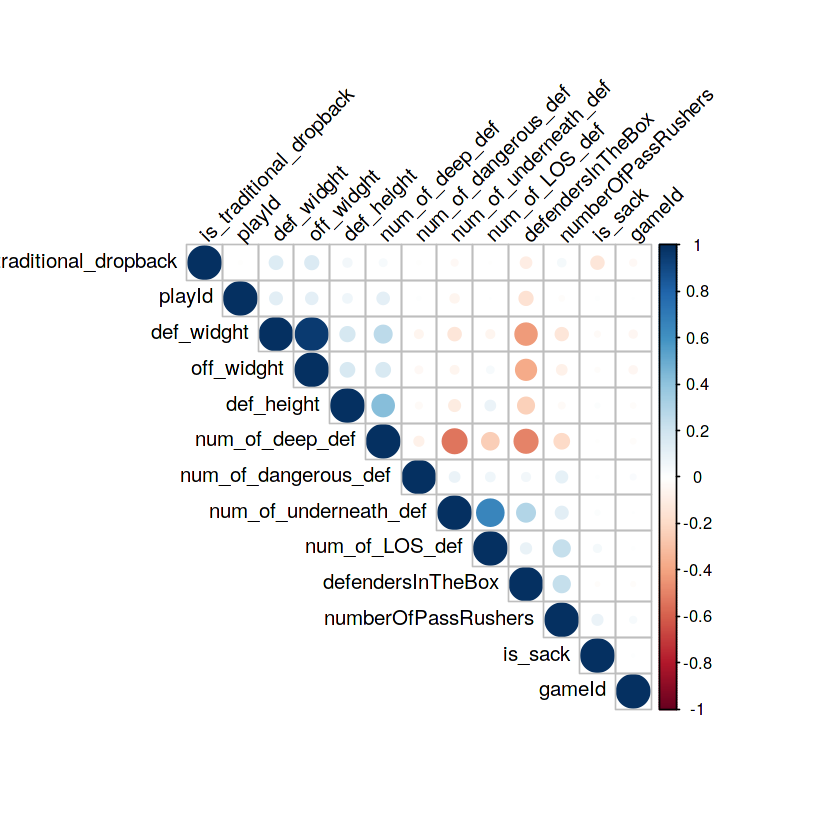

In [5]:

data_IDs <- plays_X[complete.cases(plays_X),2:3]
plays_X_Norm <- as.data.frame(lapply(plays_X[complete.cases(plays_X) ,4:ncol(plays_X)], normalize))
plays_X_Norm <- cbind(plays_X_Norm, data_IDs)
plays_X_Norm

corrplot(cor(plays_X_Norm), type = "upper", order = "hclust", tl.col = "black", tl.srt = 45)


In [6]:
#Divide the data into train and test subsets.

n = nrow(plays_X_Norm)
smp_size <- floor(0.7 * n)

index <- sample(seq_len(n),size = smp_size)
train <- plays_X_Norm[index,] %>% select(gameId, playId, is_traditional_dropback, def_widght, off_widght, def_height, num_of_deep_def, num_of_dangerous_def, num_of_underneath_def, num_of_LOS_def, defendersInTheBox, numberOfPassRushers, is_sack)
test <- plays_X_Norm[-index,] %>% select(gameId, playId, is_traditional_dropback, def_widght, off_widght, def_height, num_of_deep_def, num_of_dangerous_def, num_of_underneath_def, num_of_LOS_def, defendersInTheBox, numberOfPassRushers, is_sack)
train_features <- data.matrix(train %>% select(-is_sack, -gameId, -playId))
train_labels <- data.matrix(train %>% select(is_sack))

In [7]:
printSummary2 <- function(){
    
    SumOfPrediction <- sum(pred)
    print(paste("Sum of all predictions: ", round(SumOfPrediction, digits = 3)))
    realNumOfOccurence <- sum(test %>% select(is_sack))
    print(paste("Total real number of sacks: ", realNumOfOccurence))
    
    print("Summary of the prediction array: ")
    print(summary(round(pred, digits = 3)))
    
    example <- cbind(test %>% select(gameId, playId, is_sack), pred)
    
    print("Summary of the prediction for the plays that are actually sacks: ")
    print(summary(round(example, digits = 3) %>% filter(is_sack == 1) %>% select(is_sack ,pred)))
    print("Summary of the prediction for the plays that are NOT sacks: ")
    print(summary(round(example, digits = 3) %>% filter(is_sack == 0) %>% select(is_sack ,pred)))
    
    print("Histogram of all predictions")
    hist(example$pred)
    
    print("Example of all plays that were sacks")
    print(example %>% filter(is_sack == 1) %>% head(10))
    print("Example of some plays that were not sacks")
    print(example %>% filter(is_sack == 0) %>% head(10))
}

[1]	train-error:0.067083 
[2]	train-error:0.067083 
[3]	train-error:0.067083 
[4]	train-error:0.067083 
[5]	train-error:0.067083 
[6]	train-error:0.067083 
[1] "Sum of all predictions:  391.514"
[1] "Total real number of sacks:  388"
[1] "Summary of the prediction array: "
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.04200 0.05400 0.05800 0.07035 0.06500 0.18500 
[1] "Summary of the prediction for the plays that are actually sacks: "
    is_sack       pred        
 Min.   :1   Min.   :0.04600  
 1st Qu.:1   1st Qu.:0.05600  
 Median :1   Median :0.06300  
 Mean   :1   Mean   :0.08537  
 3rd Qu.:1   3rd Qu.:0.12925  
 Max.   :1   Max.   :0.17100  
[1] "Summary of the prediction for the plays that are NOT sacks: "
    is_sack       pred        
 Min.   :0   Min.   :0.04200  
 1st Qu.:0   1st Qu.:0.05400  
 Median :0   Median :0.05800  
 Mean   :0   Mean   :0.06923  
 3rd Qu.:0   3rd Qu.:0.06400  
 Max.   :0   Max.   :0.18500  
[1] "Histogram of all predictions"
[1] "Example of all 

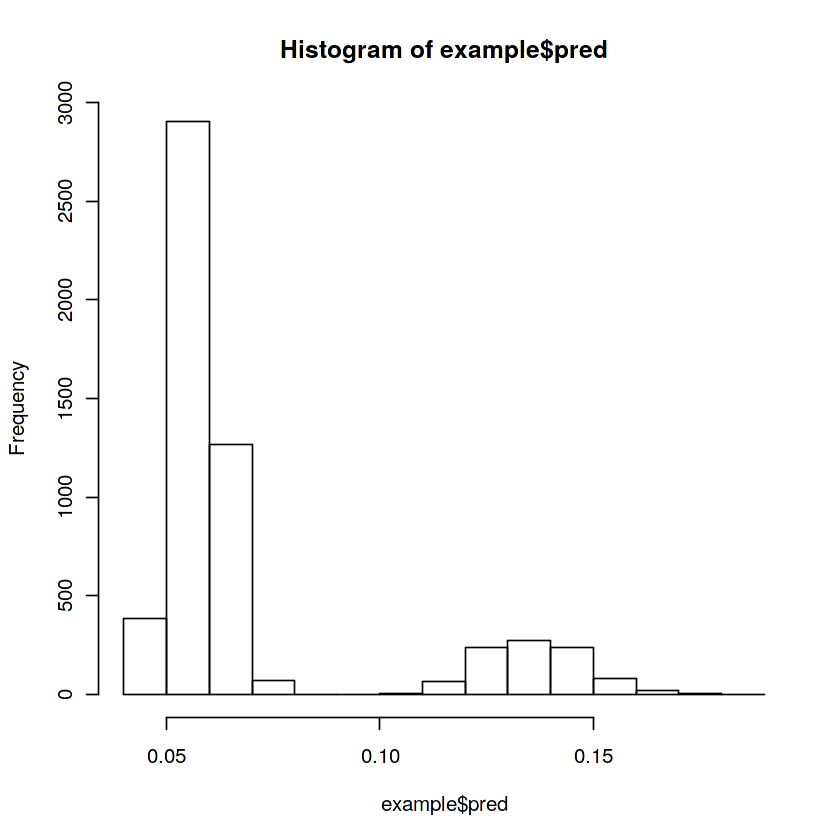

In [20]:
modelo <- execute_Xgboost()    
pred <- predict(modelo, data.matrix(test %>% select(-is_sack, -gameId, -playId)))
printSummary2()

In [9]:
###Predicting the chance of a sack using Neuralnet.
execute_Neuralnet <- function(train_X) {
    library(neuralnet)
    
    nn = neuralnet(is_sack ~ is_traditional_dropback + def_widght + off_widght + def_height + num_of_deep_def + num_of_dangerous_def + num_of_underneath_def + num_of_LOS_def + defendersInTheBox + numberOfPassRushers, data=train_X, hidden=2,
                act.fct = "logistic", err.fct = "sse", stepmax = 1e+05, linear.output = FALSE)
    
    #return(predict(nn,test))
    return(nn)
}
modelo <- execute_Neuralnet(train)
pred <- predict(modelo, test)
printSummary2()

In [7]:
printSummary3 <- function(){
    
    SumOfPrediction <- sum(pred)
    print(paste("Sum of all predictions: ", round(SumOfPrediction, digits = 3)))
    realNumOfOccurence <- sum(plays_X_Norm %>% select(is_sack))
    print(paste("Total real number of sacks: ", realNumOfOccurence))
    
    print("Summary of the prediction array: ")
    print(summary(round(pred, digits = 3)))
    
    example <- cbind(plays_X_Norm %>% select(gameId, playId, is_sack), pred)
    
    print("Summary of the prediction for the plays that are actually sacks: ")
    print(summary(round(example, digits = 3) %>% filter(is_sack == 1) %>% select(is_sack ,pred)))
    print("Summary of the prediction for the plays that are NOT sacks: ")
    print(summary(round(example, digits = 3) %>% filter(is_sack == 0) %>% select(is_sack ,pred)))
    
    print("Histogram of all predictions")
    hist(example$pred)
    
    print("Example of all plays that were sacks")
    print(example %>% filter(is_sack == 1) %>% head(10))
    print("Example of some plays that were not sacks")
    print(example %>% filter(is_sack == 0) %>% head(10))
}

[1] "Sum of all predictions:  1266.62"
[1] "Total real number of sacks:  1259"
[1] "Summary of the prediction array: "
       V1         
 Min.   :0.00000  
 1st Qu.:0.04200  
 Median :0.05600  
 Mean   :0.06829  
 3rd Qu.:0.07300  
 Max.   :0.27900  
[1] "Summary of the prediction for the plays that are actually sacks: "
    is_sack       pred       
 Min.   :1   Min.   :0.0020  
 1st Qu.:1   1st Qu.:0.0530  
 Median :1   Median :0.0720  
 Mean   :1   Mean   :0.1075  
 3rd Qu.:1   3rd Qu.:0.1515  
 Max.   :1   Max.   :0.2790  
[1] "Summary of the prediction for the plays that are NOT sacks: "
    is_sack       pred        
 Min.   :0   Min.   :0.00000  
 1st Qu.:0   1st Qu.:0.04200  
 Median :0   Median :0.05500  
 Mean   :0   Mean   :0.06543  
 3rd Qu.:0   3rd Qu.:0.07200  
 Max.   :0   Max.   :0.27900  
[1] "Histogram of all predictions"
[1] "Example of all plays that were sacks"
       gameId playId is_sack       pred
1  2018090600    776       1 0.07359756
2  2018090600    839    

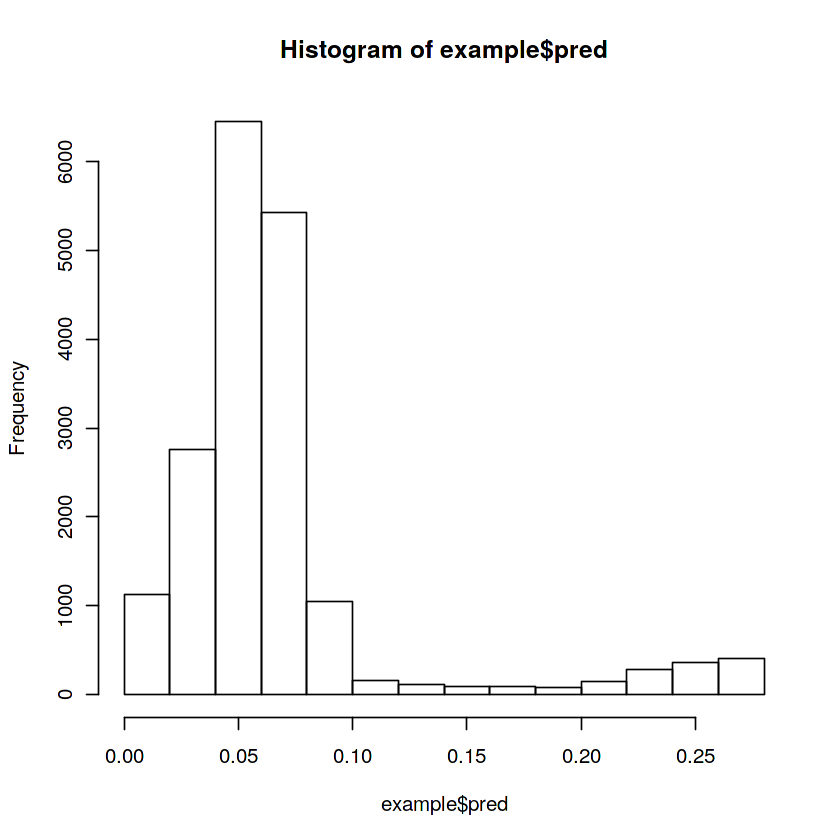

In [11]:

modelo <- execute_Neuralnet(train)
pred <- predict(modelo, plays_X_Norm)
printSummary3()

In [13]:
nrow(pred)
nrow(plays_X_Norm)

plays_w_pred <- cbind(plays_X_Norm %>% select(gameId, playId, is_sack), pred)
plays_w_pred

[1] 18549

[1] 18549

,gameId,playId,is_sack,pred
,<int>,<int>,<dbl>,<dbl>
1,2018090600,75,0,0.04077392
2,2018090600,146,0,0.03960140
3,2018090600,168,0,0.04714338
4,2018090600,190,0,0.24815252
5,2018090600,256,0,0.07806541
6,2018090600,320,0,0.03640260
7,2018090600,344,0,0.05336078
8,2018090600,402,0,0.06625479
9,2018090600,492,0,0.03160620


In [31]:
getTeamsName <- function(plays_w_pred){
    df_plays <- read_csv("../input/nfl-big-data-bowl-2021/plays.csv",
                        col_types = cols())
    df_games <- read_csv("../input/nfl-big-data-bowl-2021/games.csv",
                        col_types = cols())
    
    plays_pred_byteam <- inner_join(plays_w_pred,
                                df_plays,
                                by = c("gameId" = "gameId",
                                       "playId" = "playId"))

    plays_pred_byteam <- inner_join(plays_pred_byteam,
                                df_games,
                                by = c("gameId" = "gameId"))
    
    
    return(plays_pred_byteam %>% mutate(defenseTeam = ifelse(possessionTeam == homeTeamAbbr, visitorTeamAbbr, homeTeamAbbr)) %>% 
    select(gameId, playId, possessionTeam, defenseTeam,homeTeamAbbr, visitorTeamAbbr,is_sack, pred))
}

plays_pred_byteam <- getTeamsName(plays_w_pred)

In [26]:
teams_SAoE <- plays_pred_byteam %>% group_by(possessionTeam) %>% summarize(sum_sacks_allowed = sum(is_sack), sum_xpSA = sum(pred), SAoE=(sum_sacks_allowed - sum_xpSA)) %>% arrange(desc(SAoE))
print("Sacks allowed over expected:")
teams_SAoE

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Sacks allowed over expected:"


possessionTeam,sum_sacks_allowed,sum_xpSA,SAoE
<chr>,<dbl>,<dbl>,<dbl>
HOU,62,43.07208,18.9279248
MIA,52,34.37090,17.6290986
ARI,51,36.77781,14.2221850
TEN,47,33.52298,13.4770228
JAX,53,39.82869,13.1713141
DAL,55,42.24878,12.7512237
OAK,51,39.72245,11.2775460
SF,45,35.26246,9.7375397
SEA,45,35.87030,9.1297024



── Column specification ────────────────────────────────────────────────────────
cols(
  team = col_character(),
  team_code = col_character(),
  url = col_character()
)


Saving 12.5 x 6.67 in image



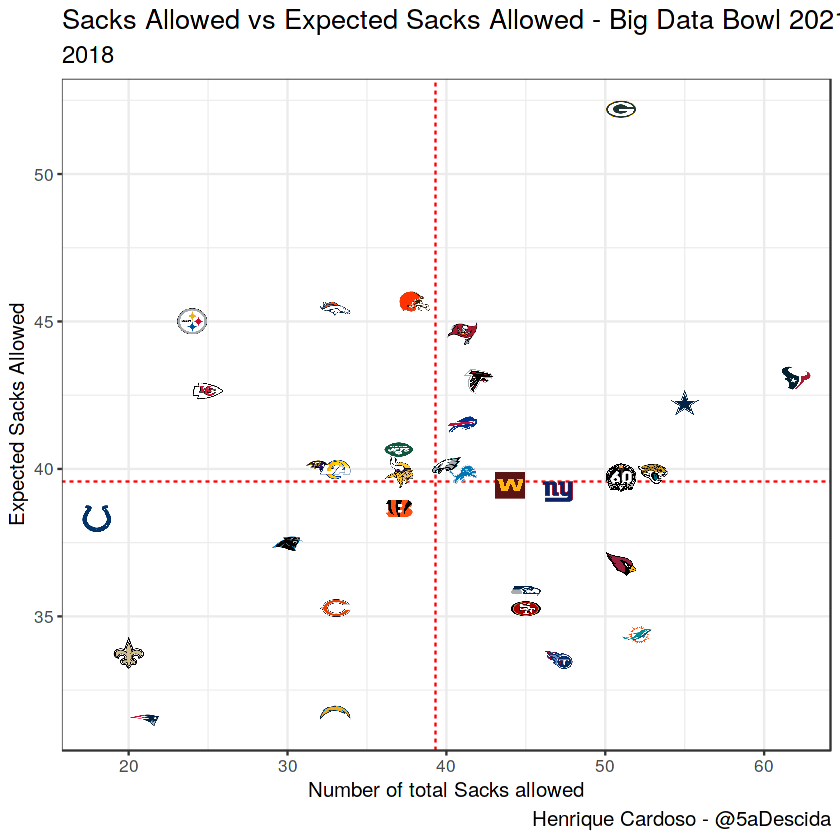

In [27]:
library(ggimage)

nfl_logos_df <- read_csv("https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv")
chart <- teams_SoE %>% left_join(nfl_logos_df, by = c("possessionTeam" = "team_code"))

chart %>%
ggplot(aes(x = sum_sacks, y = sum_xpS)) +
    geom_hline(yintercept = mean(chart$sum_xpS), color = "red", linetype = "dashed") +
    geom_vline(xintercept =  mean(chart$sum_sacks), color = "red", linetype = "dashed") +
	geom_image(aes(image = url), size = 0.04) +
	labs(x = "Number of total Sacks allowed",
	y = "Expected Sacks Allowed",
	caption = "Henrique Cardoso - @5aDescida",
	title = "Sacks Allowed vs Expected Sacks Allowed - Big Data Bowl 2021",
	subtitle = "2018") +
	theme_bw() +
	theme(axis.title = element_text(size = 12),
	axis.text = element_text(size = 10),
	plot.title = element_text(size = 16),
	plot.subtitle = element_text(size = 14),
        plot.caption = element_text(size = 12))

ggsave('FILENAME.png', dpi=72)

In [33]:
teams_SoE <- plays_pred_byteam %>% group_by(defenseTeam) %>% summarize(sum_sacks = sum(is_sack), sum_xpS = sum(pred), SoE=(sum_sacks - sum_xpS)) %>% arrange(desc(SoE))
print("Sacks over expected:")
teams_SoE

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Sacks over expected:"


defenseTeam,sum_sacks,sum_xpS,SoE
<chr>,<dbl>,<dbl>,<dbl>
MIN,47,31.00758,15.99241961
ARI,49,38.53374,10.46625909
WAS,46,37.30178,8.69821513
NO,47,39.17916,7.82083905
KC,51,43.69246,7.30754112
CHI,50,46.04088,3.95911853
LA,41,37.13542,3.86458366
SEA,42,38.20315,3.79685103
PIT,51,47.89885,3.10114563


In [34]:
library(ggimage)

nfl_logos_df <- read_csv("https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv")
chart <- teams_SoE %>% left_join(nfl_logos_df, by = c("defenseTeam" = "team_code"))

chart %>%
ggplot(aes(x = sum_sacks, y = sum_xpS)) +
    geom_hline(yintercept = mean(chart$sum_xpS), color = "red", linetype = "dashed") +
    geom_vline(xintercept =  mean(chart$sum_sacks), color = "red", linetype = "dashed") +
	geom_image(aes(image = url), size = 0.04) +
	labs(x = "Number of total Sacks",
	y = "Expected Sacks",
	caption = "Henrique Cardoso - @5aDescida",
	title = "Sacks vs Expected Sacks - Big Data Bowl 2021",
	subtitle = "2018") +
	theme_bw() +
	theme(axis.title = element_text(size = 12),
	axis.text = element_text(size = 10),
	plot.title = element_text(size = 16),
	plot.subtitle = element_text(size = 14),
        plot.caption = element_text(size = 12))

ggsave('FILENAME2.png', dpi=72)


── Column specification ────────────────────────────────────────────────────────
cols(
  team = col_character(),
  team_code = col_character(),
  url = col_character()
)




ERROR: Error: Join columns must be present in data.
[31m✖[39m Problem with `possessionTeam`.
